In [1]:
import matplotlib.pyplot as plt
import xarray as xr
from metpy.units import units
import metpy.calc as mpcalc
from datetime import datetime, timedelta

import pandas as pd
import sklearn.cluster as cluster
from sklearn.metrics import silhouette_score

In [2]:
'''
Define Model Parameters
'''
MODEL_DATE = '20230702'
MODEL_CYCLE = '12z'

# Define area of interest
LAT = 32.8998
LON = -97.0403

FORECAST_DATES = [(datetime.today() + timedelta(days=day)).strftime('%Y-%m-%d') 
                  for day in range(1, 16)]

In [3]:
base_url = f'https://nomads.ncep.noaa.gov/dods/gefs/gefs{MODEL_DATE}/gefs_pgrb2ap5_all_{MODEL_CYCLE}'

ds = xr.open_dataset(base_url, decode_times=True)

/Users/rhawthorne/miniconda3/envs/metpy/lib/python3.11/site-packages/xarray/coding/times.py:154: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [4]:
t_max = ds.tmax2m.metpy.sel(lat=LAT, lon=360+LON, method='nearest') * units('K')

In [5]:
t_max = t_max.metpy.convert_units('degF')
t_max

Magnitude,[[nan 91.4900131225586 97.24998474121094 ... 108.6770248413086 107.05703735351562 94.73004913330078] [nan 92.76030731201172 97.969970703125 ... 102.20734405517578 101.6528091430664 90.66500091552734] [nan 94.72999572753906 99.06393432617188 ... 98.24309539794922 86.71370697021484 81.20291137695312] ... [nan 95.0803451538086 98.47171783447266 ... 100.16465759277344 97.97002410888672 88.58072662353516] [nan 90.0261459350586 94.77871704101562 ... 115.77815246582031 113.86482238769531 100.12999725341797] [nan 92.40391540527344 98.16030883789062 ... 104.9812240600586 102.30413055419922 90.65862274169922]]
Units,degree_Fahrenheit


In [6]:
df = t_max.to_dataframe('temp')
df.dropna(inplace=True)
df.reset_index(inplace=True)
df

,ens,time,lat,lon,temp
0,1.0,2023-07-02 18:00:00,33.0,263.0,91.490013
1,1.0,2023-07-03 00:00:00,33.0,263.0,97.249985
2,1.0,2023-07-03 06:00:00,33.0,263.0,95.449982
3,1.0,2023-07-03 12:00:00,33.0,263.0,87.671715
4,1.0,2023-07-03 18:00:00,33.0,263.0,98.160309
...,...,...,...,...,...
1979,31.0,2023-07-17 12:00:00,33.0,263.0,92.341789
1980,31.0,2023-07-17 18:00:00,33.0,263.0,100.039139
1981,31.0,2023-07-18 00:00:00,33.0,263.0,104.981224
1982,31.0,2023-07-18 06:00:00,33.0,263.0,102.304131


In [7]:
# Only include rows with 00 UTC
# High temps usually occur in the 6 hours prior over the Americas
df = df[df['time'].dt.strftime('%H:%M:%S').str.contains('00:00:00')]

In [8]:
df.reset_index(drop=True, inplace=True)
df

,ens,time,lat,lon,temp
0,1.0,2023-07-03,33.0,263.0,97.249985
1,1.0,2023-07-04,33.0,263.0,102.099678
2,1.0,2023-07-05,33.0,263.0,101.457199
3,1.0,2023-07-06,33.0,263.0,101.680443
4,1.0,2023-07-07,33.0,263.0,101.535362
...,...,...,...,...,...
491,31.0,2023-07-14,33.0,263.0,98.357903
492,31.0,2023-07-15,33.0,263.0,105.174149
493,31.0,2023-07-16,33.0,263.0,102.183281
494,31.0,2023-07-17,33.0,263.0,104.603081


In [9]:
df_time = df.groupby(['time'])

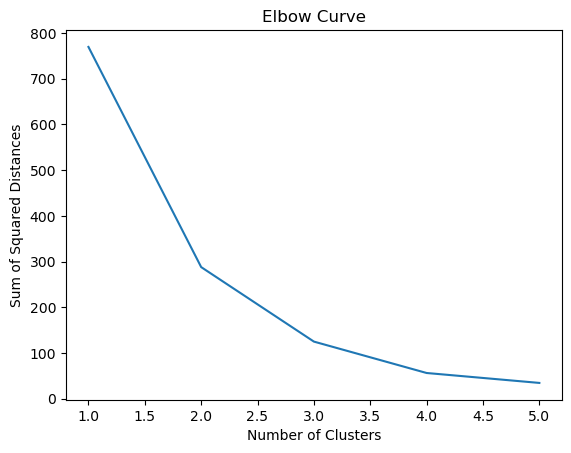

4

In [10]:
# Define the range of clusters to evaluate
clusters_range = range(1, 6)  # Adjust the range as needed

last_forecast_date = df_time.get_group(FORECAST_DATES[-1])

# Perform k-means clustering for each number of clusters and calculate the sum of squared distances
sse = []
for n_clusters in clusters_range:
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(last_forecast_date[['temp']])
    sse.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(clusters_range, sse)
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Curve')
plt.show()

# Find the elbow point
elbow_point = None
for i in range(1, len(sse) - 1):
    slope_before = sse[i] - sse[i-1]
    slope_after = sse[i+1] - sse[i]
    if slope_before / slope_after > 1:
        elbow_point = i + 1  # Adjust the index offset (starts from 1 cluster)

# Return the reasonable number of clusters based on the analysis
elbow_point

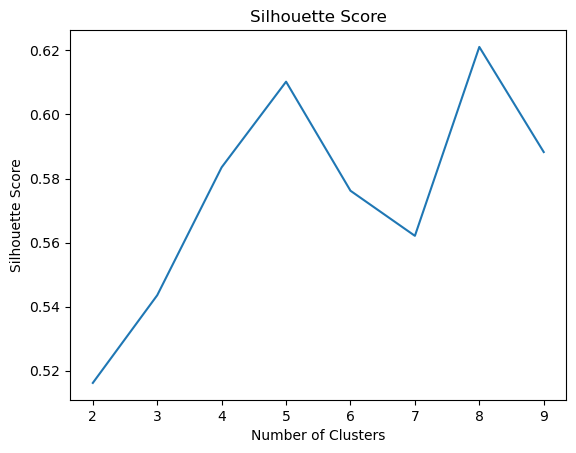

8

In [18]:
# Define the range of clusters to evaluate
clusters_range = range(2, 10)  # Adjust the range as needed

last_forecast_date = df_time.get_group(FORECAST_DATES[-1])

# Perform k-means clustering for each number of clusters and calculate the silhouette score
silhouette_scores = []
for n_clusters in clusters_range:
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(last_forecast_date[['temp']])
    silhouette_scores.append(silhouette_score(last_forecast_date[['temp']], cluster_labels))

# Plot the silhouette scores
plt.plot(clusters_range, silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.show()
silhouette_scores
max_silhouette_idx = silhouette_scores.index(max(silhouette_scores)) + 2
max_silhouette_idx

In [29]:
cluster_centers_dict = {}

for date in FORECAST_DATES:
    single_forecast_date = df_time.get_group(date)
    kmeans = cluster.KMeans(init='k-means++', n_clusters=elbow_point, n_init='auto')
    kmeans = kmeans.fit(single_forecast_date[['temp']])
    cluster_centers = kmeans.cluster_centers_.flatten()
    # Add the cluster centers to the dictionary with the date as the key
    cluster_centers_dict[date] = cluster_centers

# Create a DataFrame from the dictionary
df_cluster_centers = pd.DataFrame.from_dict(cluster_centers_dict, orient='index')
df_cluster_centers = df_cluster_centers.rename_axis('date').reset_index()

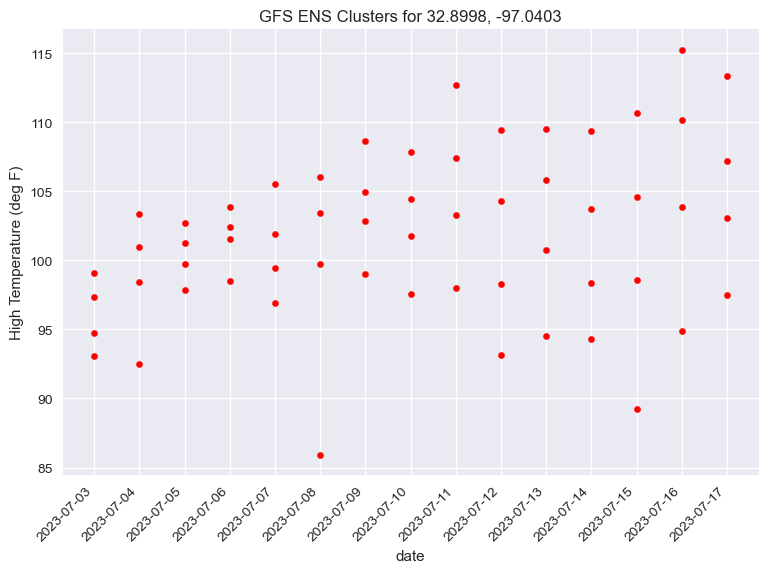

In [32]:
plt.style.use('seaborn-v0_8')
for n in range(0, elbow_point):
    ax = df_cluster_centers.plot.scatter(x='date', y=n, color='red', ax=plt.gca(),
                        title=f'GFS ENS Clusters for {LAT}, {LON}')
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel("High Temperature (deg F)")
#plt.xticks(rotation=45, ha='right')
plt.show()